In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [2]:
import copy, math

In [3]:
import plotly.express as px

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import plotly.graph_objects as go
init_notebook_mode(connected=True)

# Define all keys

In [6]:
state_key = {
'EC':'Eastern Cape',
'FS':'Free State',
'GP':'Gauteng',
'KZN':'Kwazulu Natal',
'LP':'Limpopo',
'MP':'Mpumalanga',
'NC':'Northern Cape',
'NW':'North-West',
'WC':'Western Cape'
}
state_filter = list(state_key.keys())
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [7]:
state_labels = list(state_key.values())

In [8]:
state_filter_i = copy.deepcopy(state_filter)
state_filter_i.append('Date')
state_filter_i

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

In [9]:
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [10]:
# Mid-year 2019 Estimates
# https://www.statssa.gov.za/publications/P0302/P03022019.pdf
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
province_pops = pd.read_csv(url, header=None, names=['Province','Pop'])
province_pops

,Province,Pop
0,Gauteng,15176115
1,KwaZulu-Natal,11289086
2,Western Cape,6844272
3,Eastern Cape,6712276
4,Limpopo,5982584
5,Mpumalanga,4592187
6,Northwest,4027160
7,Free State,2887465
8,Northern Cape,1263875


In [11]:
country_pop = province_pops['Pop'].sum()
country_pop

58775020

In [12]:
province_pops.iloc[0]['Pop']

15176115

# Get Latest Province Data

In [13]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_all_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=0)
states_all_i.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-06-30,20200630,27686.0,1514.0,42881.0,9674.0,1131.0,1190.0,465.0,4187.0,62481.0,0.0,151209,https://twitter.com/nicd_sa/status/12780584557...
2020-07-01,20200701,29340.0,1672.0,45944.0,10632.0,1175.0,1306.0,494.0,4393.0,64377.0,0.0,159333,https://twitter.com/nicd_sa/status/12784055720...
2020-07-02,20200702,30603.0,1886.0,49937.0,11669.0,1286.0,1478.0,573.0,4788.0,65841.0,0.0,168061,https://twitter.com/DrZweliMkhize/status/12787...
2020-07-03,20200703,32157.0,2130.0,54331.0,12757.0,1408.0,1611.0,626.0,5168.0,66936.0,0.0,177124,https://twitter.com/nicd_sa/status/12791261637...
2020-07-04,20200704,34161.0,2376.0,59373.0,13984.0,1559.0,1818.0,686.0,5644.0,68376.0,0.0,187977,https://twitter.com/nicd_sa/status/12795389507...


In [14]:
states_all = states_all_i.copy()
states_all = states_all.reset_index()
states_all = states_all.rename(columns={'date':'Date'})
states_all.tail()

,Date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
115,2020-06-30,20200630,27686.0,1514.0,42881.0,9674.0,1131.0,1190.0,465.0,4187.0,62481.0,0.0,151209,https://twitter.com/nicd_sa/status/12780584557...
116,2020-07-01,20200701,29340.0,1672.0,45944.0,10632.0,1175.0,1306.0,494.0,4393.0,64377.0,0.0,159333,https://twitter.com/nicd_sa/status/12784055720...
117,2020-07-02,20200702,30603.0,1886.0,49937.0,11669.0,1286.0,1478.0,573.0,4788.0,65841.0,0.0,168061,https://twitter.com/DrZweliMkhize/status/12787...
118,2020-07-03,20200703,32157.0,2130.0,54331.0,12757.0,1408.0,1611.0,626.0,5168.0,66936.0,0.0,177124,https://twitter.com/nicd_sa/status/12791261637...
119,2020-07-04,20200704,34161.0,2376.0,59373.0,13984.0,1559.0,1818.0,686.0,5644.0,68376.0,0.0,187977,https://twitter.com/nicd_sa/status/12795389507...


In [15]:
state_plot = states_all[state_filter_i]
state_plot

,EC,FS,GP,KZN,LP,MP,NC,NW,WC,Date
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-03-05
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-03-07
2,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2020-03-08
3,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,2020-03-09
4,0.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,1.0,2020-03-11
...,...,...,...,...,...,...,...,...,...,...
115,27686.0,1514.0,42881.0,9674.0,1131.0,1190.0,465.0,4187.0,62481.0,2020-06-30
116,29340.0,1672.0,45944.0,10632.0,1175.0,1306.0,494.0,4393.0,64377.0,2020-07-01
117,30603.0,1886.0,49937.0,11669.0,1286.0,1478.0,573.0,4788.0,65841.0,2020-07-02
118,32157.0,2130.0,54331.0,12757.0,1408.0,1611.0,626.0,5168.0,66936.0,2020-07-03


In [16]:
state_plotly = state_plot.melt(id_vars='Date', var_name='Province', value_name='Cases')
state_plotly

,Date,Province,Cases
0,2020-03-05,EC,0.0
1,2020-03-07,EC,0.0
2,2020-03-08,EC,0.0
3,2020-03-09,EC,0.0
4,2020-03-11,EC,0.0
...,...,...,...
1075,2020-06-30,WC,62481.0
1076,2020-07-01,WC,64377.0
1077,2020-07-02,WC,65841.0
1078,2020-07-03,WC,66936.0


In [17]:
#https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
colour_series = px.colors.qualitative.Vivid
colour_series

['rgb(229, 134, 6)',
 'rgb(93, 105, 177)',
 'rgb(82, 188, 163)',
 'rgb(153, 201, 69)',
 'rgb(204, 97, 176)',
 'rgb(36, 121, 108)',
 'rgb(218, 165, 27)',
 'rgb(47, 138, 196)',
 'rgb(118, 78, 159)',
 'rgb(237, 100, 90)',
 'rgb(165, 170, 153)']

In [18]:
fig = px.bar(state_plotly, title='Total Cases Per Province', x='Date', y='Cases', color='Province',
             barmode='relative', color_discrete_sequence=colour_series)
fig.update_traces(hovertemplate=None)
fig.update_layout(hovermode="x")
fig.show()

In [19]:
states_all['Actual Data'] = states_all['total'].diff()

In [20]:
smoothed = states_all['Actual Data'].rolling(7,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=2).round()

idx_start = np.searchsorted(smoothed, 25)

smoothed = smoothed.iloc[idx_start:]
states_all['Smoothed Data'] = smoothed

In [21]:
daily = states_all[['Date','Actual Data','Smoothed Data']]

In [22]:
daily_plotly = daily.melt(id_vars='Date', var_name='Range', value_name='Daily Cases')

In [23]:
fig1 = px.line(daily_plotly, title='Daily Case Increase for South Africa',
        x='Date', y='Daily Cases', color='Range', line_shape='spline')
fig1.update_traces(hovertemplate=None)
fig1.update_layout(hovermode="x")
fig1.show()

In [24]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv'
states_all_deaths = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_all_deaths.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-06-30,20200630,422,9,216,126,10,7,1,7,1859,0,2657,https://twitter.com/nicd_sa/status/12780584557...
2020-07-01,20200701,439,9,244,136,10,7,1,7,1896,0,2749,https://twitter.com/nicd_sa/status/12784055720...
2020-07-02,20200702,451,9,282,152,10,7,1,7,1925,0,2844,https://twitter.com/DrZweliMkhize/status/12787...
2020-07-03,20200703,459,9,282,162,10,7,4,36,1983,0,2952,https://twitter.com/nicd_sa/status/12791261637...
2020-07-04,20200704,490,9,282,162,10,7,4,36,2026,0,3026,https://twitter.com/nicd_sa/status/12795389507...


In [25]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv'
states_all_recover = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_all_recover.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-06-30,20200630,14081,385,10534,3602,520,464,186,651,43120,0,73543,https://twitter.com/nicd_sa/status/12780584557...
2020-07-01,20200701,14384,386,10534,3770,520,487,204,802,44938,0,76025,https://twitter.com/nicd_sa/status/12784055720...
2020-07-02,20200702,15843,386,12957,4111,570,520,232,865,46515,0,81999,https://twitter.com/DrZweliMkhize/status/12787...
2020-07-03,20200703,17403,396,14097,4197,594,585,232,865,47929,0,86298,https://twitter.com/nicd_sa/status/12791261637...
2020-07-04,20200704,18980,437,15935,4197,594,621,236,865,49362,0,91227,https://twitter.com/nicd_sa/status/12795389507...


In [26]:
cases_series = pd.Series(states_all_i['total'].values, index=states_all_i.index.values, name='Cases')
cases_series

2020-03-05         1
2020-03-07         2
2020-03-08         3
2020-03-09         7
2020-03-11        13
               ...  
2020-06-30    151209
2020-07-01    159333
2020-07-02    168061
2020-07-03    177124
2020-07-04    187977
Name: Cases, Length: 120, dtype: int64

In [27]:
deaths_series = pd.Series(states_all_deaths['total'].values, index=states_all_deaths.index, name='Deaths')
recover_series = pd.Series(states_all_recover['total'].values, index=states_all_recover.index, name='Recovered')

In [28]:
states_combine = pd.concat([cases_series, recover_series, deaths_series], axis=1)
states_combine

,Cases,Recovered,Deaths
2020-03-05,1,NaN,NaN
2020-03-07,2,NaN,NaN
2020-03-08,3,NaN,NaN
2020-03-09,7,NaN,NaN
2020-03-11,13,NaN,NaN
...,...,...,...
2020-06-30,151209,73543.0,2657.0
2020-07-01,159333,76025.0,2749.0
2020-07-02,168061,81999.0,2844.0
2020-07-03,177124,86298.0,2952.0


In [29]:
states_master = states_combine.ffill(axis=0)

In [30]:
states_changed = states_master[['Recovered','Deaths']].sum(axis=1)

In [31]:
active_all = states_master['Cases'].sub(states_changed)
active_all

2020-03-05        1.0
2020-03-07        2.0
2020-03-08        3.0
2020-03-09        7.0
2020-03-11       13.0
               ...   
2020-06-30    75009.0
2020-07-01    80559.0
2020-07-02    83218.0
2020-07-03    87874.0
2020-07-04    93724.0
Length: 120, dtype: float64

In [32]:
states_master['Active'] = active_all

In [33]:
states_master

,Cases,Recovered,Deaths,Active
2020-03-05,1,NaN,NaN,1.0
2020-03-07,2,NaN,NaN,2.0
2020-03-08,3,NaN,NaN,3.0
2020-03-09,7,NaN,NaN,7.0
2020-03-11,13,NaN,NaN,13.0
...,...,...,...,...
2020-06-30,151209,73543.0,2657.0,75009.0
2020-07-01,159333,76025.0,2749.0,80559.0
2020-07-02,168061,81999.0,2844.0,83218.0
2020-07-03,177124,86298.0,2952.0,87874.0


In [34]:
states_wide = states_master.reset_index()
states_wide = states_wide.rename(columns={'index':'Date'})
states_wide

,Date,Cases,Recovered,Deaths,Active
0,2020-03-05,1,NaN,NaN,1.0
1,2020-03-07,2,NaN,NaN,2.0
2,2020-03-08,3,NaN,NaN,3.0
3,2020-03-09,7,NaN,NaN,7.0
4,2020-03-11,13,NaN,NaN,13.0
...,...,...,...,...,...
115,2020-06-30,151209,73543.0,2657.0,75009.0
116,2020-07-01,159333,76025.0,2749.0,80559.0
117,2020-07-02,168061,81999.0,2844.0,83218.0
118,2020-07-03,177124,86298.0,2952.0,87874.0


In [35]:
state_wide_plotly = states_wide.melt(id_vars='Date', var_name='Data', value_name='Count')
state_wide_plotly

,Date,Data,Count
0,2020-03-05,Cases,1.0
1,2020-03-07,Cases,2.0
2,2020-03-08,Cases,3.0
3,2020-03-09,Cases,7.0
4,2020-03-11,Cases,13.0
...,...,...,...
475,2020-06-30,Active,75009.0
476,2020-07-01,Active,80559.0
477,2020-07-02,Active,83218.0
478,2020-07-03,Active,87874.0


In [36]:
fig2 = px.line(state_wide_plotly, x='Date', y='Count', color='Data',
              title='Covid-19 Data for South Africa', line_shape='spline')
fig2.update_traces(hovertemplate=None)
fig2.update_layout(hovermode="x")
fig2.show()

# Summmary Data

In [37]:
latestcases = states_wide.iloc[-1,:]
latest = [latestcases['Cases'], latestcases['Recovered'], latestcases['Deaths'], latestcases['Active']]
summary = [int(num) for num in latest]
summary[0]

187977

## Testing data

In [38]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_testing.csv'
states_all_tests = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_all_tests

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-04-27,20200427,14054,6317,61830,28265,3691,4385,1314,2544,33335,12908,168643,ministerial briefing 26-04-2020
2020-05-03,20200503,24835,12634,85134,45955,5626,6691,1951,3565,53967,17183,257541,https://www.nicd.ac.za/wp-content/uploads/2020...
2020-05-09,20200509,34032,17231,111630,61801,7783,9823,3092,5213,70038,20693,341336,https://www.nicd.ac.za/wp-content/uploads/2020...
2020-05-13,20200513,38122,19265,127030,67853,8239,11414,3683,5812,82865,22069,386352,https://twitter.com/bandilemasuku/status/12609...
2020-05-20,20200520,51888,24415,166394,86448,10579,14964,4776,8830,112612,25955,506681,https://twitter.com/GautengProvince/status/126...
2020-05-28,20200528,66013,34760,215959,109643,14365,18629,6061,11214,148174,30905,655723,https://twitter.com/GautengProvince/status/126...


In [39]:
states_tests = states_all_tests[state_filter]

# Evaluate district data

In [40]:
districts_gp = {
'date':'date',
'Ekurhuleni\tCases':'Ekurhuleni',
'Johannesburg\tCases':'Johannesburg',
'Sedibeng\tCases':'Sedibeng',
'Tshwane\tCases':'Tshwane',
'West Rand\tCases':'West Rand',
'West Rand\tCases':'West Rand',
'GP Unallocated\tCases':'Unknown'
}
districts = districts_gp.keys()

In [41]:
file_name = 'provincial_' + 'gp' + '_cumulative.csv'  
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/' + file_name
states_district = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

states_district_filter = states_district[districts]
col_tol = states_district_filter.sum(axis=1, numeric_only=True)
pd.options.mode.chained_assignment = None
states_district_filter['Total'] = col_tol

#states = states_filter_wp
states_district_filter.tail()

,date,Ekurhuleni\tCases,Johannesburg\tCases,Sedibeng\tCases,Tshwane\tCases,West Rand\tCases,GP Unallocated\tCases,Total
79,2020-06-29,8429.0,19529.0,1500.0,6184.0,2536.0,1663.0,39841.0
80,2020-06-30,9192.0,20918.0,1649.0,6659.0,2744.0,1719.0,42881.0
81,2020-07-01,9845.0,22388.0,1769.0,7235.0,2902.0,1805.0,45944.0
82,2020-07-02,10797.0,24244.0,1919.0,7895.0,3160.0,1922.0,49937.0
83,2020-07-03,11827.0,26293.0,2154.0,8662.0,3379.0,2016.0,54331.0


# Rt Data Import

In [42]:
#dsfsi
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True)
states_all_rt = states_all_rt.rename(columns={'date':'Date'})
states_all_rt = states_all_rt.rename(columns={'ML':'Rt'})
states_all_rt = states_all_rt.rename(columns={'state':'Province'})
states_all_rt

,Province,Date,Rt,High_90,Low_90
0,EC,2020-04-11,3.84,6.34,0.78
1,EC,2020-04-12,3.35,5.12,1.25
2,EC,2020-04-13,3.13,4.52,1.56
3,EC,2020-04-14,2.73,3.89,1.46
4,EC,2020-04-15,2.31,3.30,1.19
...,...,...,...,...,...
653,Total RSA,2020-06-30,1.40,1.52,1.26
654,Total RSA,2020-07-01,1.54,1.66,1.41
655,Total RSA,2020-07-02,1.50,1.61,1.37
656,Total RSA,2020-07-03,1.44,1.54,1.30


In [43]:
#state_single = states_rt.filter(like='Total RSA', axis=0) # for index data
state_single = states_all_rt.query("Province == 'Total RSA'")
state_single

,Province,Date,Rt,High_90,Low_90
550,Total RSA,2020-03-19,2.11,3.70,0.22
551,Total RSA,2020-03-20,2.50,3.73,1.09
552,Total RSA,2020-03-21,2.75,3.71,1.67
553,Total RSA,2020-03-22,2.87,3.67,1.99
554,Total RSA,2020-03-23,2.97,3.64,2.20
...,...,...,...,...,...
653,Total RSA,2020-06-30,1.40,1.52,1.26
654,Total RSA,2020-07-01,1.54,1.66,1.41
655,Total RSA,2020-07-02,1.50,1.61,1.37
656,Total RSA,2020-07-03,1.44,1.54,1.30


In [44]:
latestresult = state_single.iloc[-1,:]
rt = round(latestresult['Rt'], 3)
latestrt = '%.2f'%rt
latestrt

'1.35'

In [45]:
rt

1.35

In [46]:
d = latestresult['Date']
latestd = d.strftime("%d %B %Y")
latestd

'04 July 2020'

In [47]:
state_single["e_plus"] = state_single['High_90'].sub(state_single['Rt'])
state_single["e_minus"] = state_single['Rt'].sub(state_single['Low_90'])

In [48]:
fig3 = px.line(state_single, x='Date', y='Rt', color='Province',
              error_y='e_plus', error_y_minus='e_minus',
              title='Rt for Covid-19 in South Africa', line_shape='spline')
fig3.update_traces(hovertemplate=None)
fig3.update_layout(hovermode="x")
fig3['data'][0]['error_y']['color'] = 'lightblue'

fig3.show()

### Old grid subplots

In [49]:
states_rt = states_all_rt.query("Province != 'Total RSA'")
states_rt

,Province,Date,Rt,High_90,Low_90
0,EC,2020-04-11,3.84,6.34,0.78
1,EC,2020-04-12,3.35,5.12,1.25
2,EC,2020-04-13,3.13,4.52,1.56
3,EC,2020-04-14,2.73,3.89,1.46
4,EC,2020-04-15,2.31,3.30,1.19
...,...,...,...,...,...
545,WC,2020-06-30,1.08,1.27,0.86
546,WC,2020-07-01,1.16,1.35,0.94
547,WC,2020-07-02,1.17,1.36,0.96
548,WC,2020-07-03,1.13,1.31,0.91


In [50]:
grid_key = pd.DataFrame({'Province':['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC'],
                          'Row':[1,1,1,2,2,2,3,3,3],
                          'Col':[1,2,3,1,2,3,1,2,3]})

In [51]:
states_grid = states_rt.join(grid_key.set_index('Province'), on='Province')
states_grid

,Province,Date,Rt,High_90,Low_90,Row,Col
0,EC,2020-04-11,3.84,6.34,0.78,1,1
1,EC,2020-04-12,3.35,5.12,1.25,1,1
2,EC,2020-04-13,3.13,4.52,1.56,1,1
3,EC,2020-04-14,2.73,3.89,1.46,1,1
4,EC,2020-04-15,2.31,3.30,1.19,1,1
...,...,...,...,...,...,...,...
545,WC,2020-06-30,1.08,1.27,0.86,3,3
546,WC,2020-07-01,1.16,1.35,0.94,3,3
547,WC,2020-07-02,1.17,1.36,0.96,3,3
548,WC,2020-07-03,1.13,1.31,0.91,3,3


In [52]:
fig4 = px.line(states_grid, x='Date', y='Rt', color='Province', facet_row='Row', facet_col='Col',
             title='Rt for Covid-19 in South African Provinces')
fig4.update_traces(hovertemplate=None)
fig4.update_layout(hovermode="x")
fig4.show()

In [53]:
fig_px = px.line(states_rt, x='Date', y='Rt', color='Province')
fig_len = len(fig_px['data'])

In [54]:
fig5 = make_subplots(rows=3, cols=3,
                    subplot_titles=state_labels,
                    shared_xaxes=True, shared_yaxes=True)

In [55]:
r = 0
for p in range(fig_len):
    c = (p % 3) + 1
    if (c == 1):
        r+=1
    fig5.add_trace(fig_px['data'][p], row=r, col=c)

In [56]:
fig5.update_layout(title_text="Rt for Covid-19 in South African Provinces", height=700)
fig5.update_traces(hovertemplate=None)
fig5.update_layout(hovermode="x")

# Forecasts

In [57]:
cases_df = cases_series.to_frame()
cases_df = cases_df.reset_index()
cases_df = cases_df.rename(columns={'index':'Date'})
cases_df

,Date,Cases
0,2020-03-05,1
1,2020-03-07,2
2,2020-03-08,3
3,2020-03-09,7
4,2020-03-11,13
...,...,...
115,2020-06-30,151209
116,2020-07-01,159333
117,2020-07-02,168061
118,2020-07-03,177124


In [58]:
from datetime import timedelta, date

In [59]:
f = 30

In [60]:
diff = cases_df['Cases'].diff()

In [61]:
d = diff.values[-1]
d

10853.0

In [62]:
r_scenarios = [1.5, 1.4, 1.3, 1.25, 1.2, 1.15, 1.1, 1.075, 1.05, 1.025, 1.0, 0.975, 0.95, 0.925, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1]
if (rt not in r_scenarios):
    r_scenarios.append(rt)
    r_scenarios.sort(reverse=True)
r_scenarios

[1.5,
 1.4,
 1.35,
 1.3,
 1.25,
 1.2,
 1.15,
 1.1,
 1.075,
 1.05,
 1.025,
 1.0,
 0.975,
 0.95,
 0.925,
 0.9,
 0.85,
 0.8,
 0.7,
 0.6,
 0.5,
 0.25,
 0.1]

In [63]:
future_projections = None

for r in r_scenarios:
    projection = cases_df.copy()
    lastd = cases_df['Date'].iloc[-1]
    lastc = cases_df['Cases'].iloc[-1]
    d = diff.values[-1]

    for i in range(f):
        lastd += timedelta(days=1)
        newc = lastc + (d * r)
        d = newc - lastc
        lastc = newc

        calc = pd.DataFrame([[lastd, lastc]], columns=['Date', 'Cases'])
        # TODO: consider concat opertion here for faster processing
        projection = projection.append(calc)
        
    projection['R'] = r
    
    if future_projections is None:
        future_projections = projection
    else:
        future_projections = pd.concat([future_projections, projection])

future_projections

,Date,Cases,R
0,2020-03-05,1.000000,1.5
1,2020-03-07,2.000000,1.5
2,2020-03-08,3.000000,1.5
3,2020-03-09,7.000000,1.5
4,2020-03-11,13.000000,1.5
...,...,...,...
0,2020-07-30,189182.888889,0.1
0,2020-07-31,189182.888889,0.1
0,2020-08-01,189182.888889,0.1
0,2020-08-02,189182.888889,0.1


In [64]:
current_forecast = future_projections.query(f"R == {rt}")
current_forecast

,Date,Cases,R
0,2020-03-05,1.000000e+00,1.35
1,2020-03-07,2.000000e+00,1.35
2,2020-03-08,3.000000e+00,1.35
3,2020-03-09,7.000000e+00,1.35
4,2020-03-11,1.300000e+01,1.35
...,...,...,...
0,2020-07-30,1.025918e+08,1.35
0,2020-07-31,1.384477e+08,1.35
0,2020-08-01,1.868533e+08,1.35
0,2020-08-02,2.522008e+08,1.35


In [65]:
last_forecast = current_forecast.iloc[-1]
future_f = math.trunc(last_forecast['Cases'])
future_f

340419970

In [66]:
infected = future_f / country_pop * 100
f'{infected:.1f}%'

'579.2%'

In [67]:
X0 = current_forecast.iloc[0]['Date']
X1 = last_forecast['Date']
X2 = date.today()

In [68]:
max_forecast = max(current_forecast['Cases']) * 1.05
max_country = country_pop * 1.1
max_future = min(max_forecast, max_country)
max_future

64652522.00000001

In [69]:
fig6 = px.line(current_forecast, x='Date', y='Cases',
               range_y=[0, max_future],
               title='Covid-19 Cases Forecast for Current Rt')
fig6.update_traces(hovertemplate=None)
fig6.update_layout(hovermode="x")

fig6.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X2,
    y0=0,
    x1=X2,
    y1=max_future,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig6.show()

In [70]:
# pop line template
fig.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0,
    y0=country_pop,
    x1=X1,
    y1=country_pop,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

In [71]:
increasing_forecast = future_projections.query(f"R > 1")

In [72]:
fig7 = px.line(increasing_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_country],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is bigger than 1)')
fig7.update_layout(hovermode="x")
#fig7["layout"].pop("updatemenus") # to remove play controls

fig7.show()

In [73]:
linear_forecast = future_projections.query(f"R == 1")
max_linear = max(linear_forecast['Cases'])

In [74]:
fig8 = px.line(linear_forecast, x='Date', y='Cases',
               range_y=[0, max_linear],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is 1)')
fig8.update_traces(hovertemplate=None)
fig8.update_layout(hovermode="x")

fig8.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X2,
    y0=0,
    x1=X2,
    y1=max_linear,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig8.show()

In [75]:
decline_forecast = future_projections.query(f"R < 1")
max_decline = max(decline_forecast['Cases']) * 1.05

In [76]:
fig9 = px.line(decline_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_decline],
               title='Covid-19 Cases Forecast for Decreasing Cases (Rt is less than 1)')
fig9.update_traces(hovertemplate=None)
fig9.update_layout(hovermode="x")

fig9.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X2,
    y0=0,
    x1=X2,
    y1=max_decline,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig9.show()

# Matplotlib

In [77]:
repo = 'dsfsi'
url = 'https://raw.githubusercontent.com/' + repo + '/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True, index_col=[0,1])

In [78]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-06'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')
    
    return ax

In [79]:
credit = 'Source: covid19trends.co.za - Data: DSFSI'

Text(0.5, 0.98, '$R_t$ for COVID-19 in South Africa')

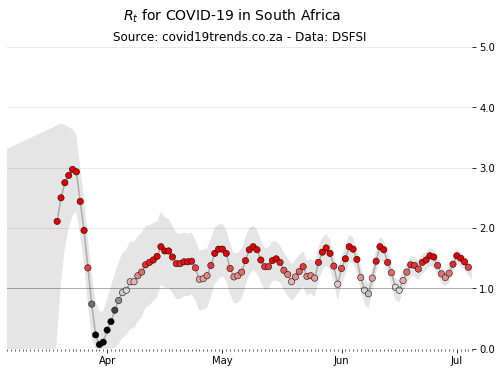

In [80]:
country = states_all_rt_i.filter(like='Total RSA', axis=0)
fig_country, ax = plt.subplots(figsize=(600/72,400/72))
ax = plot_rt(country, ax, state_name = '')
ax.set_title(credit, size=12, weight='light')
fig_country.suptitle(f'$R_t$ for COVID-19 in South Africa', size=14)

In [81]:
states_rt_i = states_all_rt_i.loc[state_filter]

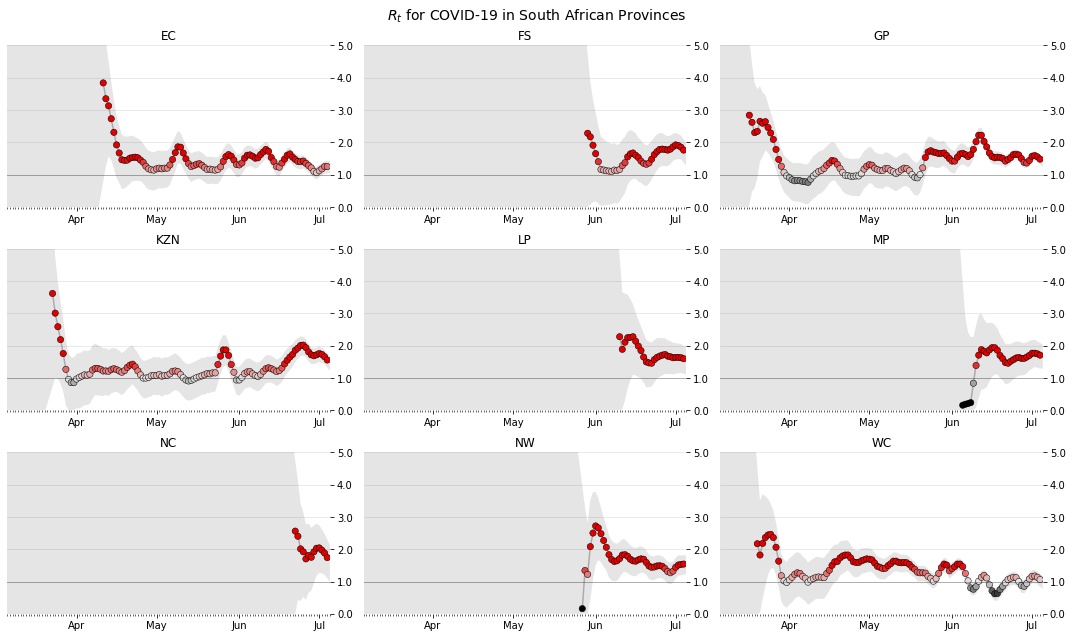

In [82]:
def all_plot(final_results):
    state_groups = final_results.groupby('state')
    
    ncols = 3
    nrows = int(np.ceil(len(state_groups) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (state_name, result) in enumerate(state_groups):
        axes.flat[i] = plot_rt(result, axes.flat[i], state_name)

    fig.tight_layout()
    fig.set_facecolor('w')
    
    fig.suptitle(f'$R_t$ for COVID-19 in South African Provinces', size=14)
    fig.subplots_adjust(top=0.92)
    
all_plot(states_rt_i)

# Standings

In [83]:
# ZA: South Arica lockdown level data as of 2020/05/03
no_lockdown = [

]
partial_lockdown = [

]
# add items as required -> 'Western Cape','WC',

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [84]:
# ZA: df slighty different to US
mr = states_all_rt_i.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

,ML,High_90,Low_90
state,,,
EC,1.25,1.42,1.04
FS,1.76,2.09,1.37
GP,1.48,1.60,1.32
KZN,1.56,1.76,1.33
LP,1.60,2.00,1.13
MP,1.71,2.09,1.30
NC,1.74,2.30,1.10
NW,1.54,1.81,1.21
Total RSA,1.35,1.45,1.22


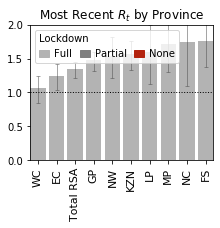

In [85]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Province'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

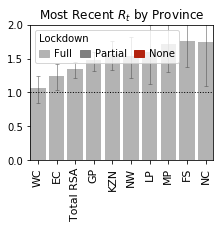

In [86]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

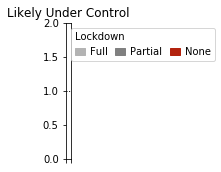

In [87]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

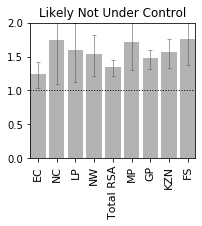

In [88]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()